In [139]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Create 2D IOR field
Input is an image where grey values map to IORs.

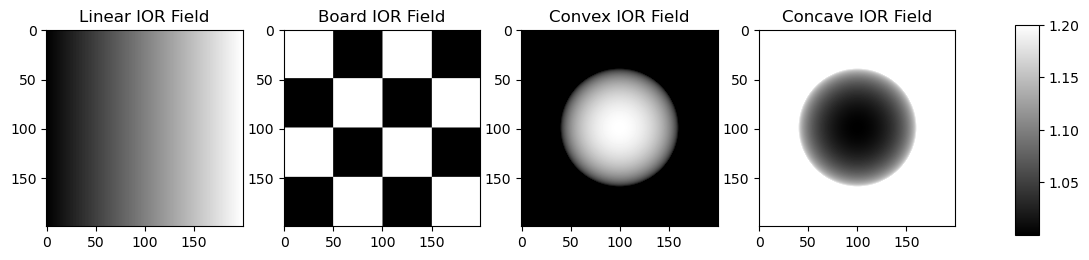

In [140]:
height, width = 200, 200
gradient = np.linspace(0, 1, width, dtype=np.float32)
linear_ior_field = np.tile(gradient, (height, 1)) * 0.2 + 1

tile_size = 50
board_ior_field = np.kron([[1, 0] * (width//tile_size//2),
                 [0, 1] * (width//tile_size//2)] * (height//tile_size//2),
                np.ones((tile_size, tile_size))) * 0.2 + 1.0

x = np.linspace(-1, 1, width)
y = np.linspace(-1, 1, height)
X, Y = np.meshgrid(x, y)
R = 0.6
r = np.sqrt(X**2 + Y**2)
n0, n1 = 1.2, 1.0
convex_lens_ior_field = n0 + (n1 - n0) * (1 - np.sqrt(1 - np.minimum(r/R, 1)**2))

n0, n1 = 1.0, 0.8
concave_lens_ior_field = n0 - (n1 - n0) * (1 - np.sqrt(1 - np.minimum(r/R, 1)**2))

plt.figure(figsize=(12, 3))
plt.subplot(141)
plt.imshow(linear_ior_field, cmap='gray')
plt.title('Linear IOR Field')
plt.subplot(142)
plt.imshow(board_ior_field, cmap='gray')
plt.title('Board IOR Field')
plt.subplot(143)
plt.imshow(convex_lens_ior_field, cmap='gray')
plt.title('Convex IOR Field')
plt.subplot(144)
plt.imshow(concave_lens_ior_field, cmap='gray')
plt.title('Concave IOR Field')


# share the same colorbar
plt.tight_layout()
plt.subplots_adjust(right=0.8)
cbar_ax = plt.gcf().add_axes([0.85, 0.15, 0.02, 0.7])
plt.colorbar(cax=cbar_ax)
plt.show()

## 2. Trace a light front (from left to right)

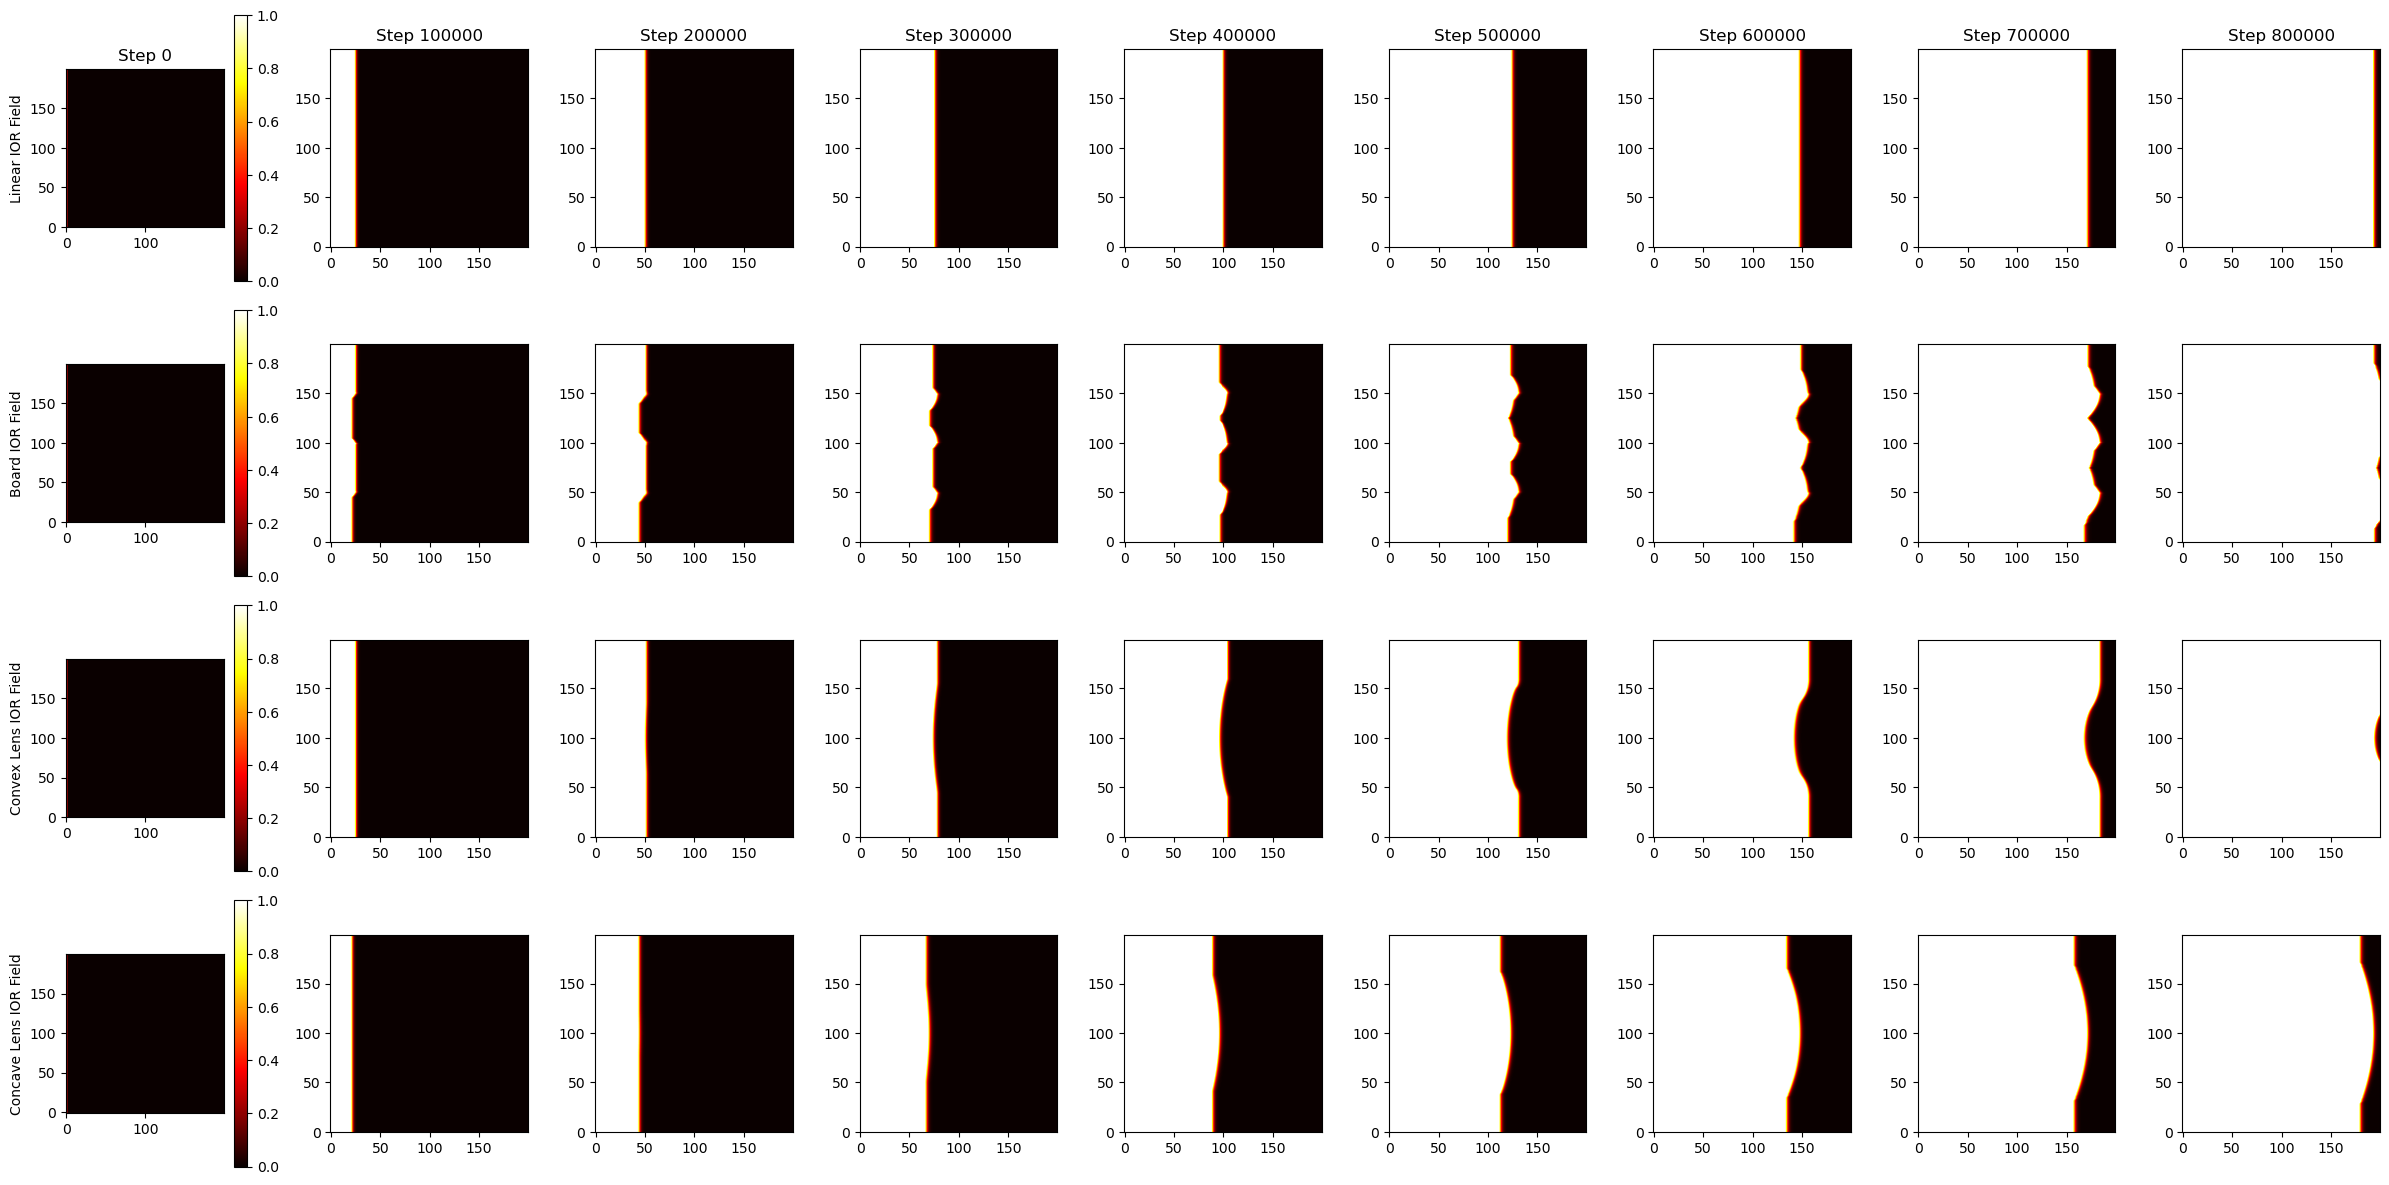

In [141]:
def propagate_wavefront(ior, wavefront, num_snap_shots, num_steps=400, step_size=0.6):
    wavefront_snapshots = []
    for step in range(num_steps):
        grad_x, grad_y = np.gradient(wavefront)
        grad = np.sqrt(grad_x**2 + grad_y**2)
        wavefront[:, 1:] += step_size * grad[:, 1:] / ior[:, 1:]
        wavefront = np.clip(wavefront, 0, 1)
        
        if step % (num_steps // num_snap_shots) == 0 or step == num_steps - 1:
            wavefront_snapshots.append(np.copy(wavefront))
    
    return wavefront_snapshots


num_steps = 800000
num_snap_shots = 8
height, width = 200, 200
ior_fields = [linear_ior_field, board_ior_field, convex_lens_ior_field, concave_lens_ior_field]
titles = ['Linear IOR Field', 'Board IOR Field', 'Convex Lens IOR Field', 'Concave Lens IOR Field']


plt.figure(figsize=(24, 12))
for i, ior in enumerate(ior_fields):
    wavefront = np.zeros((height, width))
    wavefront[:, 0] = 1.0
    wavefront_snapshots = propagate_wavefront(ior, wavefront, num_snap_shots)
    for j, snapshot in enumerate(wavefront_snapshots):
        plt.subplot(len(ior_fields), len(wavefront_snapshots), i * len(wavefront_snapshots) + j + 1)
        plt.imshow(snapshot, cmap='hot', origin='lower', vmin=0, vmax=1)
        if j == 0:
            plt.colorbar()
            plt.ylabel(titles[i])
        if i == 0:
            plt.title(f'Step {j * (num_steps // num_snap_shots)}')        

plt.tight_layout()
plt.show()